In [1]:
import pandas as pd

import numpy as np

#importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("C:/Users/Thandazani/Movie Recommender System/train.csv", usecols=['userId', 'movieId', 'rating','timestamp'],dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})
movies = pd.read_csv("C:/Users/Thandazani/Movie Recommender System/movies.csv", usecols=['movieId','title'], dtype={'movieId':'int32','title':'str'})

In [3]:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [4]:
movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [5]:
#checkinng for NaN values
movies_df = movies
movies_df.isnull().sum()

movieId    0
title      0
dtype: int64

In [6]:
ratings_df = train
ratings_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [7]:
print("Movies:",movies_df.shape)
print("Ratings:",ratings_df.shape)

Movies: (62423, 2)
Ratings: (10000038, 4)


Merging the imported Datasets for Analysis

In [8]:
#movies_df.info()
#ratings_df.info()
movies_merged_df=movies_df.merge(ratings_df, on='movieId')
movies_merged_df.head()

,movieId,title,userId,rating,timestamp
0,1,Toy Story (1995),158849,5.0,994716786
1,1,Toy Story (1995),97203,5.0,942683155
2,1,Toy Story (1995),161871,3.0,833104576
3,1,Toy Story (1995),45117,4.0,1442256969
4,1,Toy Story (1995),27431,5.0,849667827


In [9]:
movies_merged_df=movies_merged_df.dropna(axis = 0, subset = ['title'])
movies_merged_df.head()

,movieId,title,userId,rating,timestamp
0,1,Toy Story (1995),158849,5.0,994716786
1,1,Toy Story (1995),97203,5.0,942683155
2,1,Toy Story (1995),161871,3.0,833104576
3,1,Toy Story (1995),45117,4.0,1442256969
4,1,Toy Story (1995),27431,5.0,849667827


In [10]:
movies_average_rating=movies_merged_df.groupby('title')['rating'].mean().sort_values(ascending=False).reset_index().rename(columns={'rating':'Average Rating'})
movies_average_rating.head()

,title,Average Rating
0,Which Way Home (2009),5.0
1,Kaakha Kaakha (2003),5.0
2,Not Quite Human II (1989),5.0
3,Selling Isobel (2018),5.0
4,Sehar (2005),5.0


In [11]:
movies_rating_count=movies_merged_df.groupby('title')['rating'].count().sort_values(ascending=True).reset_index().rename(columns={'rating':'Rating Count'}) #ascending=False
movies_rating_count_avg=movies_rating_count.merge(movies_average_rating, on='title')
movies_rating_count_avg.head()

,title,Rating Count,Average Rating
0,"""BLOW THE NIGHT!"" Let's Spend the Night Togeth...",1,3.0
1,Love's Coming (2014),1,2.5
2,Love's Brother (2004),1,1.5
3,Love's Abiding Joy (2006),1,3.5
4,Love on the Dole (1941),1,3.0


Observation-

Many movies have a pefrect 3 star average rating on a dataset of almost 100k user ratings. This suggests the existence of outliers which we need to further confirm with visualization.
The presence of single ratings for several movies suggests that I set a threshold value of ratings to produce valuable recommendations

Data Visualization

we will focus on creating plots to prove the observations and analyze the trends in the data (if any). we will stick to seaborn and matplotlib for this project.

In [12]:
#Other additional visualization libraries
sns.set(font_scale = 1)
plt.rcParams["axes.grid"] = False
plt.style.use('dark_background')
%matplotlib inline

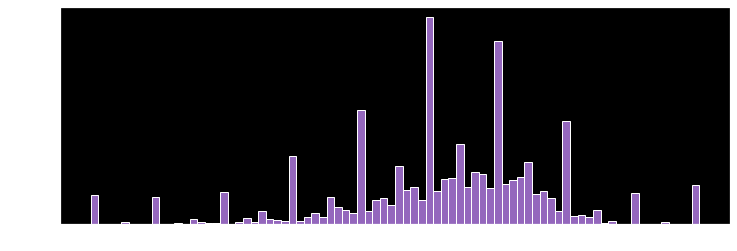

In [13]:
plt.figure(figsize=(12,4))
plt.hist(movies_rating_count_avg['Average Rating'],bins=80,color='tab:purple')
plt.ylabel('Average Rating',fontsize=16)
plt.savefig('avgratinghist.jpg')

Analysis-

Plot #1 confirms our observations of a high volume of movies with low ratings count. Apart from setting a threshold, we can also use quantiles at some higher percentile for this usecase.

Histogram #2 showcases the distribution function of the Average Rating values.

Joinplot beautifully illustrates that there is only a subset of values with higher rating that have considerable amount of ratings.

Eliminating Outliers

In [14]:
rating_with_RatingCount = movies_merged_df.merge(movies_rating_count, left_on = 'title', right_on = 'title', how = 'left')
rating_with_RatingCount.head()

,movieId,title,userId,rating,timestamp,Rating Count
0,1,Toy Story (1995),158849,5.0,994716786,23062
1,1,Toy Story (1995),97203,5.0,942683155,23062
2,1,Toy Story (1995),161871,3.0,833104576,23062
3,1,Toy Story (1995),45117,4.0,1442256969,23062
4,1,Toy Story (1995),27431,5.0,849667827,23062


In [15]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(rating_with_RatingCount['Rating Count'].describe())

count   10000038.000
mean        5964.803
std         6568.236
min            1.000
25%         1196.000
50%         3656.000
75%         8285.000
max        32831.000
Name: Rating Count, dtype: float64


In [16]:
popularity_threshold = 50
popular_movies= rating_with_RatingCount[rating_with_RatingCount['Rating Count']>=popularity_threshold]
popular_movies.head()
popular_movies.shape

(9744920, 6)

#### selecting only 1000000 rows from popola movies dataset

In [17]:
popular_movies=popular_movies.head(700000)
popular_movies.shape

(700000, 6)

Pivotting title as indices & userId as columns

In [18]:
import os
movie_features_df=popular_movies.pivot_table(index='title',columns='userId',values='rating').fillna(0)
movie_features_df.head()

userId,2,3,5,7,8,9,10,12,13,15,...,162529,162530,162531,162533,162534,162535,162537,162538,162539,162541
title,,,,,,,,,,,,,,,,,,,,,
Ace Ventura: When Nature Calls (1995),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
"Addiction, The (1995)",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Amateur (1994),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
"Amazing Panda Adventure, The (1995)",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
"American President, The (1995)",0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


# COLLABORATIVE FILTERING 1

### Creating kNN Model 1

In [19]:
from scipy.sparse import csr_matrix
movie_features_df_matrix = csr_matrix(movie_features_df.values)

In [20]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(movie_features_df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [21]:
movie_features_df.shape

(237, 127201)

In [22]:
query_index = np.random.choice(movie_features_df.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(movie_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

184


In [23]:
movie_features_df.head()

userId,2,3,5,7,8,9,10,12,13,15,...,162529,162530,162531,162533,162534,162535,162537,162538,162539,162541
title,,,,,,,,,,,,,,,,,,,,,
Ace Ventura: When Nature Calls (1995),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
"Addiction, The (1995)",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Amateur (1994),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
"Amazing Panda Adventure, The (1995)",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
"American President, The (1995)",0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [24]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(movie_features_df.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, movie_features_df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Race the Sun (1996):

1: It Takes Two (1995), with distance of 0.9094099402427673:
2: Bushwhacked (1995), with distance of 0.9442301988601685:
3: Houseguest (1994), with distance of 0.9462174773216248:
4: Kid in King Arthur's Court, A (1995), with distance of 0.9466983079910278:
5: Waiting to Exhale (1995), with distance of 0.9467563033103943:


# COLLABORATIVE FILTERING 2

### Creating kNN Model 2

#### selecting only 300000 rows from train dataset for ratings

In [25]:
ratings = train.head(300000)
ratings.shape

(300000, 4)

In [26]:
data = ratings.pivot_table(index = 'movieId',columns = 'userId',values ='rating').fillna(0)
data.head()

userId,1,2,3,4,6,8,9,12,13,15,...,162532,162533,162534,162535,162536,162537,162538,162539,162540,162541
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [27]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

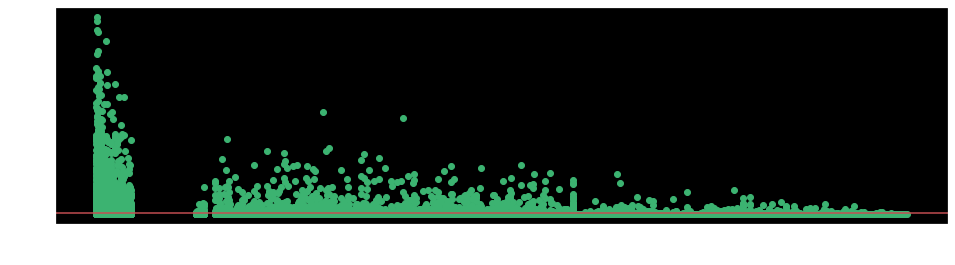

In [28]:
f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [29]:
final_dataset =data.loc[no_user_voted[no_user_voted > 10].index,:]

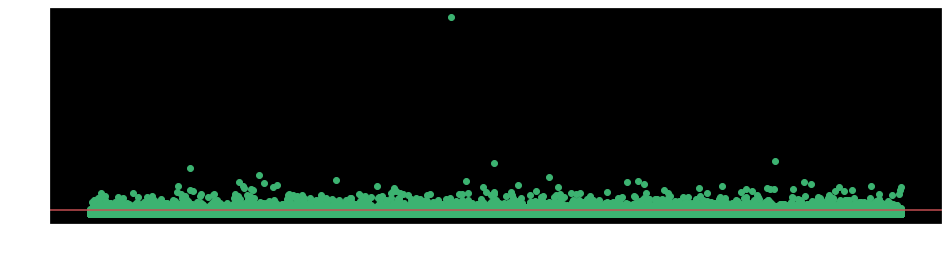

In [30]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [31]:
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 10].index]
final_dataset

userId,12,187,284,431,494,541,548,606,626,653,...,162271,162349,162358,162368,162394,162445,162484,162495,162508,162516
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195159,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
196997,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
197711,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [32]:
sample = np.array([[0,0,3,0,0],[4,0,0,0,2],[0,0,0,0,1]])
sparsity = 1.0 - ( np.count_nonzero(sample) / float(sample.size) )
print(sparsity)

0.7333333333333334


In [33]:
csr_sample = csr_matrix(sample)
print(csr_sample)

  (0, 2)	3
  (1, 0)	4
  (1, 4)	2
  (2, 4)	1


In [34]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

In [35]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [36]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    else:
        return "No movies found. Please check your input"

In [37]:
get_movie_recommendation('Iron Man')

,Title,Distance
1,Miami Vice (2006),0.888
2,Once Upon a Time in Hollywood (2019),0.877
3,"Other Guys, The (2010)",0.876
4,THX 1138 (1971),0.876
5,"Blind Side, The (2009)",0.867
6,"Spanish Apartment, The (L'auberge espagnole) (...",0.866
7,"Blob, The (1988)",0.864
8,Dawn of the Dead (1978),0.855
9,Coal Miner's Daughter (1980),0.855
10,Baby Geniuses (1999),0.822


In [38]:
get_movie_recommendation('Memento')

,Title,Distance
1,"Invisible Man, The (1933)",0.900
2,"Truly, Madly, Deeply (1991)",0.900
3,"Lovely Bones, The (2009)",0.899
4,Boyz N the Hood (1991),0.898
5,Taking Lives (2004),0.895
6,Breaking Away (1979),0.890
7,"Avengers, The (1998)",0.883
8,Chocolat (1988),0.876
9,"Way, Way Back, The (2013)",0.864
10,"Legend of 1900, The (a.k.a. The Legend of the ...",0.860


In [40]:
get_movie_recommendation('Invisible Man, The')

,Title,Distance
1,Captain Phillips (2013),0.818
2,Igby Goes Down (2002),0.804
3,Perfect Blue (1997),0.794
4,"Crucible, The (1996)",0.776
5,Koyaanisqatsi (a.k.a. Koyaanisqatsi: Life Out ...,0.768
6,Sleeping with the Enemy (1991),0.756
7,Escape to Witch Mountain (1975),0.742
8,20 Dates (1998),0.696
9,"Avengers, The (1998)",0.687
10,"Legend of 1900, The (a.k.a. The Legend of the ...",0.558
